# RAINBOW agent playing 2048 with [ReLAx](https://github.com/nslyubaykin/relax)

For ReLAx installation see: https://github.com/nslyubaykin/relax/blob/master/README.md

!Note: For examining trained actor you may just load trained policies. To do that, firstly download models and put them into /trained_models directory, then, instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/rainbow_for_2048

# Play the game manually in Jupyter:

To define game function we will use `Game2048` class from game_engine.py file of this repository. You may examine it if you are interested in the back-end of 2048 game.

In [1]:
import matplotlib.pyplot as plt

from game_engine import Game2048


def play_2048(grid_size=4, max_pow=13):
    
    valid_input = ['w', 'a', 's', 'd']
    
    print(f'Type {valid_input} to move tiles')
    print(f'Type "q" to exit the game')
    
    # Initialize the 2048 Game  
    game = Game2048(grid_size=grid_size,
                    max_pow=max_pow)
    game.add_new_2()
    game_over = game.is_game_over()
    total_score = game.score
    steps_made = 0
    
    # start gaming loop
    while not game_over:
        
        # print game state
        print('---------------')
        print(f'Score: {game.score}, Inc Rew.: {game.score - total_score}, Steps made: {steps_made}')
        plt.imshow(game.render(True))
        plt.show()
        
        total_score = game.score
        
        # request action
        acs = str(input('Your Move:')).lower()
        
        # check if it valid
        while not acs in valid_input+['q']:
            print(f'Invalid action: {acs}')
            print(f'Type {valid_input} to move tiles')
            print(f'Type "q" to exit the game')
            acs = str(input('Your Move:')).lower()
        
        # Make action
        change = False
        if acs == 'w':
            change = game.move_up()
        elif acs == 'a':
            change = game.move_left()
        elif acs == 's':
            change = game.move_down()
        elif acs == 'd':
            change = game.move_right()
        elif acs == 'q':
            print('---------------')
            print(f'Score: {game.score}, Inc Rew.: {game.score - total_score}, Steps made: {steps_made}')
            plt.imshow(game.render(True))
            plt.show()
            print(f'GAME QUIT, your score: {game.score}')
            break
            
        # add new 2 to the grid
        # if grid is affected by action
        if change:
            game.add_new_2()
        
        # check if game is over
        game_over = game.is_game_over()
        
        if game_over:
            print('---------------')
            print(f'Score: {game.score}, Inc Rew.: {game.score - total_score}, Steps made: {steps_made}')
            plt.imshow(game.render(True))
            plt.show()
            print(f'GAME OVER, your score: {game.score}')
            
        steps_made += 1
            

Type ['w', 'a', 's', 'd'] to move tiles
Type "q" to exit the game
---------------
Score: 0, Inc Rew.: 0, Steps made: 0


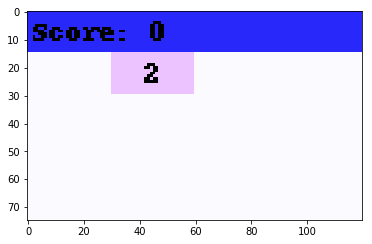

Your Move:d
---------------
Score: 0, Inc Rew.: 0, Steps made: 1


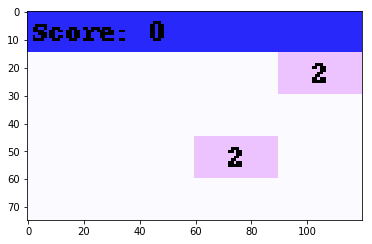

Your Move:w
---------------
Score: 0, Inc Rew.: 0, Steps made: 2


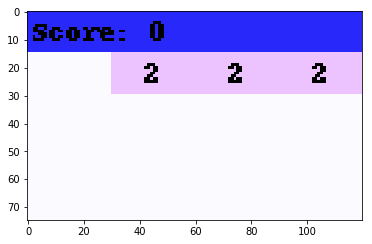

Your Move:d
---------------
Score: 4.0, Inc Rew.: 4.0, Steps made: 3


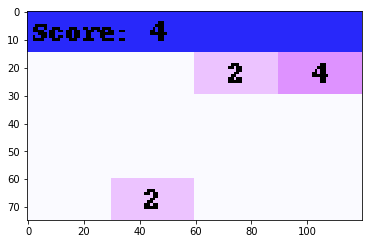

Your Move:w
---------------
Score: 4.0, Inc Rew.: 0.0, Steps made: 4


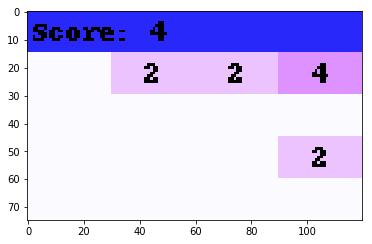

Your Move:d
---------------
Score: 8.0, Inc Rew.: 4.0, Steps made: 5


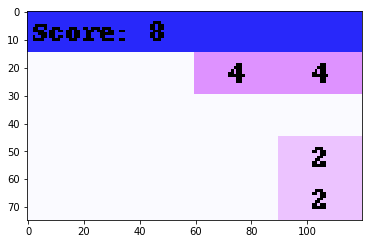

Your Move:d
---------------
Score: 16.0, Inc Rew.: 8.0, Steps made: 6


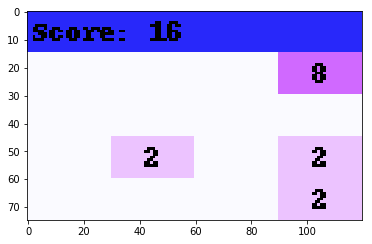

Your Move:w
---------------
Score: 20.0, Inc Rew.: 4.0, Steps made: 7


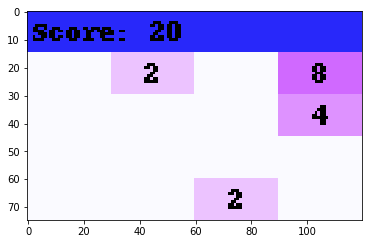

Your Move:d
---------------
Score: 20.0, Inc Rew.: 0.0, Steps made: 8


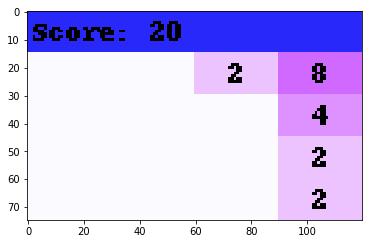

Your Move:w
---------------
Score: 24.0, Inc Rew.: 4.0, Steps made: 9


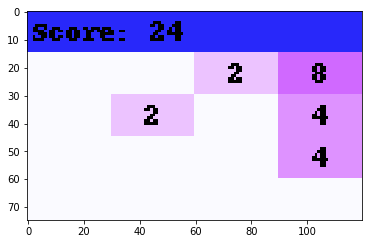

Your Move:w
---------------
Score: 32.0, Inc Rew.: 8.0, Steps made: 10


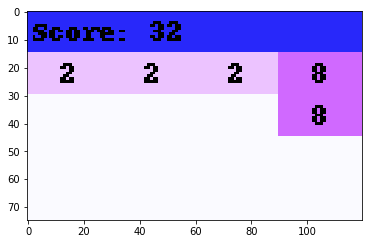

Your Move:w
---------------
Score: 48.0, Inc Rew.: 16.0, Steps made: 11


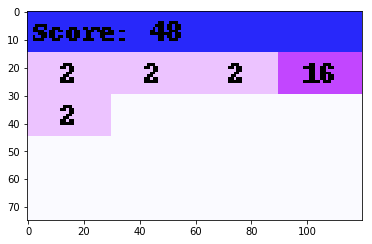

Your Move:d
---------------
Score: 52.0, Inc Rew.: 4.0, Steps made: 12


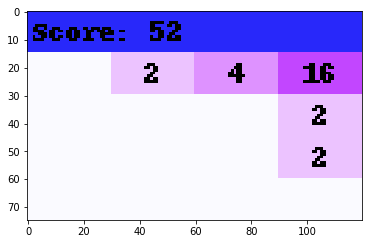

Your Move:q
---------------
Score: 52.0, Inc Rew.: 0.0, Steps made: 12


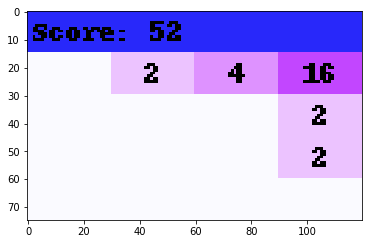

GAME QUIT, your score: 52.0


In [3]:
# Explore your human-expert performance right in Jupyter!
play_2048(grid_size=4, max_pow=16)

# Create Gym environment:

ReLAx works with Gym-like environments, and in order to work properly, custom environment should be inherited from
`gym.Env` and have the following methods:

Mandatory methods:

1) `reset()` - which resets environment state to start a new rollout

2) `step()` - which takes action array as an input and returns (next_obs, reward, done, info) `tuple`

Methods to visualize environment

1) `render()` - renders environment's state for visualization

2) `close()` - closes all `cv2` windows with states visualization

! Note: For an environment to work with `relax.rl.actors.Random` actor `self.action_space` attribute should be defined through `gym.spaces` class  as it uses `sample()` method of `gym.spaces` classes.

In more detail custom environment based on 2048 game base logic definition is shown below:

In [24]:
import cv2 
import gym
import numpy as np

from gym import Env, spaces

class Game2048Env(Env):
    
    """
    Gym Environment Built on top of
    2048 Game engine from game_engine.py
    """
    
    # To enable rendering with gym.wrappers.Monitor
    metadata = {'render.modes': ['human', 'rgb_array']}
    
    def __init__(self, 
                 grid_size=4, 
                 max_pow=13,
                 grayscale=True,
                 max_same_actions=20):
        
        """
        Args:
        
            grid_size: the number of tiles forming the
            playing square grid. Default: 4
            
            max_pow: the maximum tile value (2**max_pow)
            after reaching which the episode terminates.
            Default: 13 (8192)
            
            grayscale: whether to return gray images
            with 1 channel as states. Default: True
            
            max_same_actions: the maximum number of 
            sequentially made identical actions that 
            do not change the state of the game.
            After reaching it, episode will terminate.
            If None, episode won't due to any number of
            max_same_actions. Default: 20
            
        """
        
        # initialize 2048 game engine
        self.grid_size = grid_size
        self.max_pow = max_pow
        self.grayscale = grayscale
        
        self.max_same_actions = max_same_actions
        if self.max_same_actions is not None:
            self.acs_history = []
            self.change_history = []
        
        self.game = Game2048(grid_size=grid_size,
                             max_pow=max_pow)
        
        # Add randomly 2 to the grid
        self.game.add_new_2()
        
        # observation attrs
        self.observation_shape = (
            self.game.cell_height * self.game.grid_size,
            self.game.cell_width * self.game.grid_size,
            3
        )
        
        self.observation_space = spaces.Box(
            low = np.zeros(self.observation_shape).astype(np.uint8), 
            high = (np.ones(self.observation_shape)*255).astype(np.uint8),
            dtype = np.uint8
        )
        
        # Define an action space ranging from 0 to 4
        # !Note `self.action_space` should be defined
        # through `gym.spaces` class to 
        # work with `relax.rl.actors.Random` actor
        # as it uses `sample()` method of `gym.spaces` classes
        self.action_space = spaces.Discrete(4,)
        self.action_meanings = ['LEFT', 'RIGHT', 'UP', 'DOWN']
        
    def check_same_actions(self):
        
        """
        Method to check if `self.max_same_actions` last
        actions were the same and did not yield any change in state
        
        If `self.max_same_actions` is not None
        Environment will terminate episode after 
        `self.max_same_actions` same actions that did not change the state
        
        Done to avoid 'frozen' actor`s behavior and
        therefore too long trivial rollouts
        """
        
        same_actions = False
        
        if self.max_same_actions is not None:
            
            if len(self.acs_history) >= self.max_same_actions:
                
                assert len(self.acs_history) == len(self.change_history)
                
                # manage history length
                self.acs_history = self.acs_history[-self.max_same_actions:]
                self.change_history = self.change_history[-self.max_same_actions:]
                
                # Check if all last actions implied no change
                no_change = np.logical_not(self.change_history)
                no_change = all(no_change)
                
                # Check if all last actions were the same
                n_diff_acs = len(set(self.acs_history))
                same_acs = n_diff_acs == 1
                
                same_actions = no_change and same_acs
                
        return same_actions
            
    def reset(self) -> np.ndarray:
        
        """
        Reset environment to start a new rollout
        
        Returns:
        
            obs: `np.ndarray` - A numpy array containing initial 
            environment state
        """
        
        # Reset game state
        self.game.reset()
        
        # Reset acs history
        if self.max_same_actions is not None:
            self.acs_history = []
            self.change_history = []
        
        # Add randomly 2 to the grid
        self.game.add_new_2()
        
        # Render initial obs
        obs = self.game.render()
        
        if self.grayscale:
            obs = obs[:, :, 0] * 0.299 + obs[:, :, 1] * 0.587 + obs[:, :, 2] * 0.114
            obs = np.round(np.expand_dims(obs, -1)).astype(np.uint8)
        
        return obs.copy()
    
    def render(self, mode = "human"):
        
        """
        Render environment state for
        visualization
        """
        
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Game", 
                       self.game.render(add_score=True)) # Render with score
            cv2.waitKey(10)

        elif mode == "rgb_array":
            return self.game.render(add_score=True)

    def close(self):
        
        """
        Close all cv2 windows
        """
        
        cv2.destroyAllWindows()
        
    def get_action_meanings(self):
        return self.action_meanings
    
    def step(self, action):
        
        """
        A method to step the environment
        
        Args:
        
            action: `np.array` with a shape () or `int` - for discrete case.
                    `np.array` with a shape (*acs_dim) - for continuos case
                    
        Returns a tuple of:
            
            obs: `np.array` with a state obtained after environment 
                 step. May also be referred as a next state
                 
            rew: scalar (`int` or `float`) representing the reward
                 collected after environment step
            
            done: `bool` indicating whether an environment state
                  obtained after this step is terminal
                  aka last in the episode
            
            info: `dict` with some additional information if needed
                  In `gym` envs tipycally contains
                  'TimeLimit.truncated' field which
                  indicates if an episode was terminated 
                  due to the time limit rather then 
                  actual termination criteria
        
        """
        
        # Check if an action within the valid range
        if not self.action_space.contains(action):
            raise ValueError(
                f"Action: {action} is not within valid range"
            )
        
        info = {'TimeLimit.truncated': False}
            
        # some logs before step
        st_score = self.game.score
        info['max_tile'] = int(self.game.mat.max().copy())
        
        # Perform the action inside the game
        change = False
        
        if action == 0:
            change = self.game.move_left()
            self.acs_history.append(0)
        elif action == 1:
            change = self.game.move_right()
            self.acs_history.append(1)
        elif action == 2:
            change = self.game.move_up()
            self.acs_history.append(2)
        elif action == 3:
            change = self.game.move_down()
            self.acs_history.append(3)
            
        # Add action and change to logs
        self.change_history.append(change)
            
        # If game state is changed - sample new 2
        if change:
            self.game.add_new_2()
            
        # Check if game is over
        game_over = self.game.is_game_over()
        
        # Check if reached max tile (here may be considered as a time limit)
        if self.game.mat.max() >= self.game.max_value:
            info['TimeLimit.truncated'] = True
            
        # Compute incremental reward after step
        rew = self.game.score - st_score
        
        # render observation after env step
        obs = self.game.render()
        
        if self.grayscale:
            obs = obs[:, :, 0] * 0.299 + obs[:, :, 1] * 0.587 + obs[:, :, 2] * 0.114
            obs = np.round(np.expand_dims(obs, -1)).astype(np.uint8)
            
        # check for N same actions condition
        same_actions = self.check_same_actions()
        
        done = game_over or same_actions
            
        return obs.copy(), rew, done, info
    

# Create reward wrapper:

For training we will use an environment wrapper with rewards clipped to 1. In this setting, agent won't see the difference in merging small tiles vs big tiles and will act in order to avoid termination. As a side effect of this behavior, large tiles should be achieved.

In [25]:
from math import log2

class ClipRews(gym.Wrapper):  
    
    """
    Computes r_new = clip(r_old, a_max=1, a_min=None)
    """
    
    def __init__(self, env):
        
        gym.Wrapper.__init__(self, env)
        
    def _cliprew(self, reward):
        
        out_reward = 0
        
        if reward > 0:
            out_reward = 1
        
        return out_reward
    
    def step(self, action):
        
        # Step an unwrapped environment
        obs, reward, done, info = self.env.step(action)
        
        # Log unwrapped return to info
        info['raw_rews'] = reward
        
        return obs, self._cliprew(reward), done, info


# Defining RAINBOW critic:

!Note: The detailed RAINBOW explanation may be found [here](https://github.com/nslyubaykin/relax_rainbow_dqn_example/blob/master/rainbow_dqn_tutorial.ipynb). For the brevity of the example it will be omitted.

In [4]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.critics import CategoricalDQN
from relax.rl.actors import ArgmaxQValue

from relax.zoo.critics import AtariDistributionalNoisyDuelingQCNN

from relax.schedules import PiecewiseSchedule, LinearSchedule, ConstantSchedule, CombinedSchedule
from relax.exploration import EpsilonGreedy

from relax.gym.utils import get_wrapper_by_name, visualize_actor
from relax.gym.wrappers.atari import *

from relax.data.sampling import Sampler
from relax.data.replay_buffer import ReplayBuffer

/home/nikita/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constructing Distributional Discrete Deep Q-Network Critic for 2048

Rainbow DQN is a distributional discrete action RL algorithm. That means that critic net is taking as an input an observations batch with a shape of (BATCH_SIZE, \*obs.shape) (for Atari domain observation is a batch of stacked frames which then processed by CNN feature extractor) and outputting a a tensor of log probabilities with a shape (batch_size, acs_dim, n_atoms).

!Note:
            
critic_net should have these attributes:

- v_min - minimal support value of categorical distribution

- v_max - maximal support value of categorical distribution

- n_atoms - number of categorical distribution support elements

- d_z - step of categorical distribution support =
    (v_max-v_min)/(n_atoms-1)

- support: torch.FloatTensor - categorical distribution support
    which should be registered in model's buffer
    
# Dueling Architecture

Dueling architecture implies splitting output layers (following after CNN feature extractor for Atari) of the deep Q network into two streams: values stream (output shape: (BATCH_SIZE, 1, N_ATOMS)) and advantages stream (output shape: (BATCH_SIZE, ACS_DIM, N_ATOMS)). Later V's and A's are used to calculate Q-values. Intuitively, the dueling architecture can learn which states are (or are not) valuable, without having to learn the effect of each action for each state.

    
# Noisy Layers

NoisyNets are neural networks whose weights and biases are perturbed by a parametric function of the noise. These parameters are adapted with gradient descent. To implement NoisyNets use `relax.zoo.layers.NoisyLinear` instead of `torch.nn.Linear`.

Therefore any custom user defined networks meeting this requirements should work well with `CategoricalDQN` critic

__Keeping this in mind let's build neural network for RAINBOW critic__:

In [5]:
import torch

from torch import nn
from torch.nn import functional as F

from relax.zoo.layers import NoisyLinear
from relax.zoo.critics import PreprocessImg


class QCNN_2048(nn.Module):
    
    """
    This network is almost entirely the same as default
    Atari-2600 implementation available at:
    `relax.zoo.critics.AtariDistributionalNoisyDuelingQCNN`
    except `self.conv_net` parameters that are tuned
    to work with an input of shape (N, 60, 96, 3)
    """
    
    def __init__(self, in_channels, acs_dim,
                 n_atoms, v_min, v_max,
                 std_init=0.5):
        
        super(QCNN_2048, self).__init__()
        
        # Categorical DQN specific params
        self.n_atoms = n_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.d_z = (v_max-v_min)/(n_atoms-1)
        self.register_buffer('support', torch.Tensor(n_atoms))
        self.support.data.copy_(
            torch.tensor(
                [v_min + i*self.d_z for i in range(n_atoms)]
            )
        )

        self.acs_dim = acs_dim
        
        self.conv_net = nn.Sequential(
            PreprocessImg(),
            nn.Conv2d(in_channels=in_channels, out_channels=48, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=72, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=72, out_channels=72, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        self.advantages_fc = nn.Sequential(
            NoisyLinear(2304, 512, std_init=std_init), # Hardcoded
            #nn.Linear(2304, 512),
            nn.ReLU(),
            NoisyLinear(512, acs_dim * n_atoms, std_init=std_init),
            #nn.Linear(512, acs_dim * n_atoms),
        )
        
        self.values_fc = nn.Sequential(
            NoisyLinear(2304, 512, std_init=std_init), # Hardcoded
            #nn.Linear(2304, 512),
            nn.ReLU(),
            NoisyLinear(512, 1 * n_atoms, std_init=std_init),
            #nn.Linear(512, 1 * n_atoms),
        )
        
    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor: 
        
        features = self.conv_net(x)
        
        advantages = self.advantages_fc(features)
        values = self.values_fc(features)
        
        advantages = advantages.view(-1, self.acs_dim, self.n_atoms)
        values = values.view(-1, 1, self.n_atoms)
        
        logits = values + (advantages - advantages.mean(1, keepdim=True))
        
        log_probs = F.log_softmax(logits, dim=-1)
        
        return log_probs

__!Note:__ On some systems `relax.zoo.layers.NoisyLinear` seems to leak memory. This issue is very unpredictable and yet not fully understood. Sometimes, installing different versions of PyTorch and CUDA may fix it. If the problem persists, as a workaround, consider not using noisy linear layers and add some non-zero exploration `eps` to `EpsilonGreedy`

# Define Schedules for Training:

Learning rate:

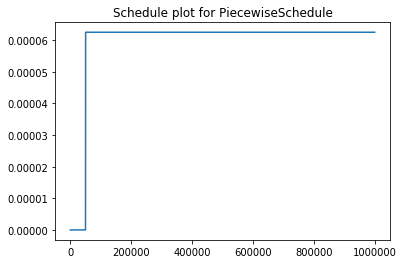

In [6]:
lr_schedule = PiecewiseSchedule({0: 50000}, 0.0000625) #1e-4
lr_schedule.plot(int(1e6))

Importance-sampling correction ($ {\beta} $)

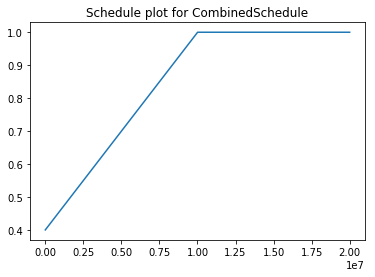

In [7]:
betta_schedule1 = LinearSchedule(0.4, 1, 10000000)
betta_schedule2 = ConstantSchedule(1)
betta_schedule = CombinedSchedule(betta_schedule1, betta_schedule2, min)
betta_schedule.plot(int(2e7))

# Create training and eval environments

In [8]:
env = ClipRews(Game2048Env(4, 13)) # Wrapped Training Env
eval_env = Game2048Env(4, 13) # Unwrapped Env for Evaluation

# Visualize environment observations:

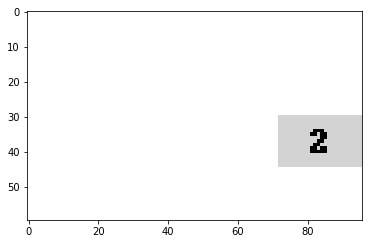

((60, 96, 1), dtype('uint8'))

In [9]:
ob = eval_env.reset()
plt.imshow(ob.squeeze(), cmap='gray')
plt.show()
ob.shape, ob.dtype

In [10]:
env.action_space

Discrete(4)

In [11]:
acs_dim = 4

# Define ArgmaxQValue actor

In [12]:
actor = ArgmaxQValue(
    exploration=EpsilonGreedy(
        eps=PiecewiseSchedule(
            {1: 50000}, # First 50k steps
            0 # Residual steps
        )
    )
)

# Define CategoricalDQN critic:

In [13]:
critic = CategoricalDQN( # Distributional
    critic_net=QCNN_2048(  # Noisy + Dueling + Distributional
        in_channels=1, # 1 for grayscale, 3 for RGB
        acs_dim=acs_dim, 
        n_atoms=51,
        v_min=-10, #-5
        v_max=100 #45
    ),
    device=torch.device('cuda'),
    learning_rate=lr_schedule,
    batch_size=32,
    gamma=0.99,
    target_updates_freq=32000, #10000
    n_steps_per_update=1,
    #grad_norm_clipping=15, #10
    update_freq=4,
    prioritized_sampling=True, # Prioritized
    alpha=0.5, #0.6
    betta=betta_schedule,
    priority_eps=1e-4, #1e-3
    double_q=True, # Double
    n_step_learning=3, # N-step
)

# Provide actor with critic:

In [14]:
actor.set_critic(critic)

# Wrap envs into `Sampler`:

In [15]:
sampler = Sampler(env)
eval_sampler = Sampler(eval_env)

# Create prioritized replay buffer

!Note: `ReplayBuffer` is designed not to store lags explicitly (and not to store next states also) that is why the number of lags will not affect the amount of RAM used. However, as it still has to store 1m. experience history and each observation is an array of shape (60, 96, 1) with a dtype uint8, the total amount of RAM usage by ReplayBuffer $ \approx $ 10^6 \* 60 \* 96 \* 1 bytes ~= 5.5 gigabytes. In total, training requires $ \approx $ 9-11 gigabytes of RAM. If your machine does not have enough RAM - consider:

1) Decreasing buffer size.

2) Lowering environments `max_pow` arg. This will decrease grid cell size (required to fill cell value number) and therefore decrease obs image width. However, that will require manual reingeneering of `QCNN_2048` conv net

In [16]:
replay_buffer = ReplayBuffer(
    int(1e6),
    prioritized_learners=[critic] # Prioritized
) 
replay_buffer.prioritizers

{'uniform': <relax.data.prioritization.UniformReference at 0x7fce1432b208>,
 'CategoricalDQN_140523079270016': <relax.data.prioritization.SumTree at 0x7fce1432b160>}

# Visualize untrained actor

In [20]:
visualize_actor(env=eval_env, actor=actor, nsteps=10000, train_sampling=False)

/home/nikita/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Simulation done, total reward: 4.0
Loading video...


# Run Training and Validation loop:

In [21]:
log_every = 50000
n_steps = 10000000
logdir = '/home/nikita/Desktop/RelaxExamples/RAINBOW_2048/tensorboard_logs'
run_name = f'rainbow_dqn_2048_game_mp13'
logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')
all_logs = []

for step in tqdm(range(n_steps)): 
    
    # sample training batch
    unit_pathlist = sampler.sample(actor=actor,
                                   n_transitions=1,
                                   max_path_length=None, 
                                   reset_when_not_done=False,
                                   train_sampling=True)
    
    # add transitions to replay buffer
    replay_buffer.add_paths(unit_pathlist)
    
    # update critic
    critic_logs = critic.update(replay_buffer)
        
    # update actor
    actor_logs = actor.update(replay_buffer)
    
    if step % log_every == 0 and step > 0:
        
        # run evaluation on unwrapped environment
        eval_batch = eval_sampler.sample_n_episodes(
            n_episodes=5,
            actor=actor,
            max_path_length=None, 
            train_sampling=False
        )
        
        eval_logs = eval_batch.create_logs(prefix='eval')
        
        # create logs of replay buffer
        buffer_logs = replay_buffer.create_logs(prefix='buffer')

        logs = {**critic_logs,
                **actor_logs,
                **buffer_logs,
                **eval_logs
               }
        all_logs.append(logs)
        
        for key, value in logs.items():
            logger.add_scalar(key, value, step)
    
logger.flush()

100%|██████████| 10000000/10000000 [24:44:42<00:00, 112.26it/s]  


In [33]:
%load_ext tensorboard
%tensorboard --logdir /home/nikita/Desktop/RelaxExamples/RAINBOW_2048/tensorboard_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 182310), started 1 day, 1:38:42 ago. (Use '!kill 182310' to kill it.)

# Plot learning curve

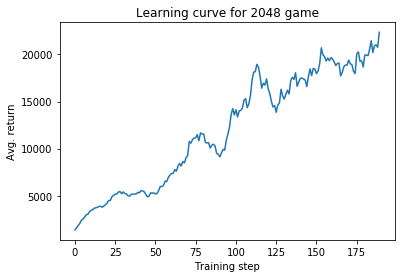

In [27]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

eval_score = [l['avg_return/eval'] for l in all_logs]
plt.plot(moving_average(eval_score, w=10))
plt.title(f'Learning curve for 2048 game')
plt.xlabel('Training step')
plt.ylabel('Avg. return')
plt.show()

# Plot estimated vs actual Q-values

('avg_return', 1131.2)
('std_return', 517.4626170072578)
('max_return', 1738)
('min_return', 315)
('mean_pathlen', 1405.1)
('n_paths', 10)
('n_transitions', 14051)


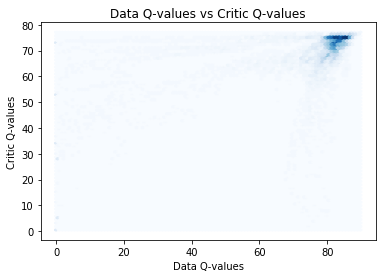

In [28]:
batch = sampler.sample_n_episodes(actor=actor, #Note: wrapped reward!
                                  n_episodes=10,
                                  max_path_length=None, 
                                  train_sampling=False)

print(*batch.create_logs().items(), sep='\n')

batch.add_disc_cumsum(cumsum_field='q_vals', field='rews', gamma=0.99)
data_q_values = batch.unpack(['q_vals'])

model_q_values = critic.estimate_qvalue(batch)

plt.hexbin(data_q_values, model_q_values, bins=50, cmap=plt.cm.Blues)
plt.title('Data Q-values vs Critic Q-values')
plt.xlabel('Data Q-values')
plt.ylabel('Critic Q-values')
plt.show()

# Analyze agent's performance

In [34]:
n_paths = 100

test_env = Game2048Env(4, 13) # Unwrapped Env for Evaluation
test_sampler = Sampler(test_env, 
                       info_parse=['max_tile'])

avg_return_vec = []
tile_summary = {}

for p in range(1, 14):
    tile_summary[str(2**p)] = []
    
for _ in tqdm(range(n_paths)):
    
    path = test_sampler.sample_n_episodes(
        n_episodes=1,
        actor=actor,
        train_sampling=False
    )
    
    avg_return_vec.append(
        path.create_logs()['avg_return']
    )
    
    max_tile = int(path.unpack(['max_tile']).max())
    
    for k, v in tile_summary.items():
        
        if int(k) <= max_tile:
            v.append(1)
        else:
            v.append(0)
            
for k, v in tile_summary.items():
    tile_summary[k] = np.mean(v)
    
avg_return = np.mean(avg_return_vec)

print(f'Experiment done, avg. return: {avg_return}')

100%|██████████| 100/100 [05:06<00:00,  3.07s/it]

Experiment done, avg. return: 21972.16


# Probability of reaching each tile:

In [65]:
print(*tile_summary.items(), sep='\n')

('2', 1.0)
('4', 1.0)
('8', 1.0)
('16', 1.0)
('32', 1.0)
('64', 1.0)
('128', 1.0)
('256', 0.99)
('512', 0.98)
('1024', 0.83)
('2048', 0.52)
('4096', 0.01)
('8192', 0.0)


# Visualize trained actor

In [32]:
# Unwrapped reward
visualize_actor(env=eval_env, actor=actor, nsteps=10000, train_sampling=False)

/home/nikita/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Simulation done, total reward: 40720.0
Loading video...


# Save Models

In [29]:
actor.save_checkpoint('trained_models', 'argmax_q_value_actor')
critic.save_checkpoint('trained_models', 'rainbow_dqn_critic')

Saved checkpoints for ArgmaxQValue...
exploration_global_step global_step
Saved checkpoints for CategoricalDQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler


# Load Models

In [17]:
!unzip trained_models

Archive:  trained_models.zip
   creating: trained_models/
  inflating: trained_models/argmax_q_value_actor.pth  
  inflating: trained_models/rainbow_dqn_critic.pth  


In [18]:
actor.load_checkpoint('trained_models', 'argmax_q_value_actor')
critic.load_checkpoint('trained_models', 'rainbow_dqn_critic')

Loaded checkpoints for ArgmaxQValue...
exploration_global_step global_step
Loaded checkpoints for CategoricalDQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler
